### Imports

In [1]:
import pandas as pd
import numpy as np
from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

### Boolean Variables

In [2]:
pnl = 0
max_pnl = 0
trade_side = 0
entry_price = None
max_drawdown = 0
take_profit = 1.5
stop_loss = 2
trade = False
entry_condition = None

### Get Data and Resample Time Frames

In [3]:
# Extract Data
hf = h5py.File("data/binance.h5")
existing_data = hf["BTCUSDT"][:]
data = sorted(existing_data, key=lambda x: x[0])
data = np.array(data)

df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Volume"])
df["Date"] = pd.to_datetime(df["Date"].values.astype(np.int64), unit="ms")
df.set_index("Date", drop=True, inplace=True)

In [4]:
# Resample data to time frames
TF_EQUIV = {"1m": "1Min", "5m": "5Min", "15m": "15Min", "30m": "30Min", "1h": "1H", "4h": "4H", "12h": "12H", "1d": "D"}
def resample_timeframe(data: pd.DataFrame, tf: str) -> pd.DataFrame:
    return data.resample(TF_EQUIV[tf]).agg(
        {"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})

In [5]:
data = resample_timeframe(df, '30m')
data = data[['Open','High','Low','Close']]
data

,Open,High,Low,Close
Date,,,,
2022-01-06 00:30:00,43646.18,43661.14,43594.54,43656.00
2022-01-06 01:00:00,43655.99,43766.00,43489.85,43576.40
2022-01-06 01:30:00,43577.27,43639.72,43290.47,43525.91
2022-01-06 02:00:00,43525.90,43600.00,43111.00,43226.14
2022-01-06 02:30:00,43225.97,43434.00,43192.83,43248.40
...,...,...,...,...
2022-12-15 17:30:00,17411.70,17424.40,17381.60,17392.10
2022-12-15 18:00:00,17392.10,17415.20,17380.30,17397.40
2022-12-15 18:30:00,17397.30,17398.20,17310.00,17395.50


In [6]:
# Add Returns and Range
df = data.copy()
df['Returns'] = (df['Close'] / df['Close'].shift(1)) - 1
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True)
print(f'Len: {len(df)}')
df.head()

Len: 16502


,Open,High,Low,Close,Returns,Range
Date,,,,,,
2022-01-06 01:00:00,43655.99,43766.00,43489.85,43576.40,-0.001823,0.006350
2022-01-06 01:30:00,43577.27,43639.72,43290.47,43525.91,-0.001159,0.008068
2022-01-06 02:00:00,43525.90,43600.00,43111.00,43226.14,-0.006887,0.011343
2022-01-06 02:30:00,43225.97,43434.00,43192.83,43248.40,0.000515,0.005584
2022-01-06 03:00:00,43248.39,43300.00,43061.63,43082.06,-0.003846,0.005536


In [7]:
# Add Moving Average
df['MA_200 High'] = df['High'].rolling(window=200).mean()
df['MA_200 Low'] = df['Low'].rolling(window=200).mean()

In [8]:
# Add RSI and it's moving average

# Calculate the different between the value of one row and the value of the row before
delta = df['Close'].diff()
rsi_length = 14
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0  # Keep only the negative change, others are set to 0

avg_gain = up.ewm(com=(rsi_length- 1), min_periods=rsi_length).mean()
avg_loss = down.abs().ewm(com=(rsi_length - 1), min_periods=rsi_length).mean()

rs = avg_gain / avg_loss  # Relative Strength

rsi = 100 - 100 / (1 + rs)
rsi = rsi.round(2)
df['RSI'] = rsi
df['MA_RSI']= rsi.rolling(14).mean()

In [9]:
# ADX
period = 14
alpha = 1 / period
adx_ma_length = 12

# TR
df['H-L'] = df['High'] - df['Low']
df['H-C'] = np.abs(df['High'] - df['Close'].shift(1))
df['L-C'] = np.abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
del df['H-L'], df['H-C'], df['L-C']

# ATR
df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

# +-DX
df['H-pH'] = df['High'] - df['High'].shift(1)
df['pL-L'] = df['Low'].shift(1) - df['Low']
df['+DX'] = np.where(
    (df['H-pH'] > df['pL-L']) & (df['H-pH'] > 0),
    df['H-pH'],
    0.0
)
df['-DX'] = np.where(
    (df['H-pH'] < df['pL-L']) & (df['pL-L'] > 0),
    df['pL-L'],
    0.0
)
del df['H-pH'], df['pL-L']

# +- DMI
df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
df['+DMI'] = (df['S+DM'] / df['ATR']) * 100
df['-DMI'] = (df['S-DM'] / df['ATR']) * 100
del df['S+DM'], df['S-DM']

# ADX
df['DX'] = (np.abs(df['+DMI'] - df['-DMI']) / (df['+DMI'] + df['-DMI'])) * 100
df['ADX'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()
del df['DX'], df['ATR'], df['TR'], df['-DX'], df['+DX'], df['+DMI'], df['-DMI']
df['MA_ADX'] = df['ADX'].rolling(adx_ma_length).mean()

In [10]:
df.dropna(inplace=True)

In [12]:
# Structure Data
X_train = df[['Returns', 'Range']].iloc[:5435]
X_test = df[['Returns', 'Range']].iloc[5435:]
save_df = df.iloc[5435:]

print(f'Train Length: {len(X_train)}')
print(f'Test Length: {len(X_test)}')
print(f'X_train from: {X_train.head(1).index.item()}')
print(f'X_train to: {X_train.tail(1).index.item()}')
print(f'X_test from: {X_test.head(1).index.item()}')
print(f'X_test to: {X_test.tail(1).index.item()}')

Train Length: 5435
Test Length: 10868
X_train from: 2022-01-10 04:30:00
X_train to: 2022-05-03 09:30:00
X_test from: 2022-05-03 10:00:00
X_test to: 2022-12-15 19:30:00


### Train HMM

In [13]:
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
# Make Prediction on Test Data
df_main = save_df.copy()

hmm_results = model.predict([X_test.values])[0]
df_main['HMM'] = hmm_results
df_main.head()

,Open,High,Low,Close,Returns,Range,MA_200 High,MA_200 Low,RSI,MA_RSI,ADX,MA_ADX,HMM
Date,,,,,,,,,,,,,
2022-05-03 10:00:00,38455.2,38480.7,38375.5,38449.9,-0.000138,0.002741,38591.3155,38388.3280,45.77,49.147857,11.863768,13.631819,0
2022-05-03 10:30:00,38449.9,38457.3,38351.7,38414.0,-0.000934,0.002753,38585.7345,38382.8365,43.64,48.711429,11.525908,13.293272,0
2022-05-03 11:00:00,38414.0,38483.6,38250.0,38466.5,0.001367,0.006107,38580.5175,38377.0650,47.49,48.717143,12.000134,13.037277,0
2022-05-03 11:30:00,38466.5,38569.7,38422.0,38561.9,0.002480,0.003844,38575.3000,38371.6805,53.68,49.037857,11.615703,12.775416,0
2022-05-03 12:00:00,38561.9,38612.9,38404.6,38452.8,-0.002829,0.005424,38570.2670,38366.4115,46.88,48.927143,10.876786,12.500416,0


### Run Backtest

In [15]:
# Trade signal test
df_main.loc[(df_main['Close'] > df_main['MA_200 High']) & (df_main['ADX'] > 31) & (df_main['RSI'] > 74) & (df_main['MA_RSI'] < df_main['RSI']) & (df_main['MA_ADX'] < df_main['ADX']), 'Signal'] = 1
df_main.loc[(df_main['Close'] < df_main['MA_200 Low']) & (df_main['ADX'] > 31) & (df_main['RSI'] < 30) & (df_main['MA_RSI'] > df_main['RSI']) & (df_main['MA_ADX'] < df_main['ADX']), 'Signal'] = -1
df_main['Signal'].fillna(0, inplace=True)
df_main['Signal'] = df_main['Signal'].shift(1)
# df_main['Entry Price'] = 0
# df_main['Close Price'] = 0

In [25]:

combination = [[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [0, 1, 2], [0, 1, 2, 3], [1, 2, 3], [1, 3], [2, 3]]
profit_list_index = []
profit_list = []
pnl_list_list = []
# Add HMM Signals
for c in combination:
    favourable_states = c
    hmm_values = df_main['HMM'].values
    hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
    df_main['HMM_Signal'] = hmm_values

    # Add Combined Signal
    df_main['Main_Signal'] = 0
    df_main.loc[(df_main['Signal'] == 1) & (df_main['HMM_Signal'] == 1), 'Main_Signal'] = 1
    df_main.loc[(df_main['Signal'] == -1) & (df_main['HMM_Signal'] == 1), 'Main_Signal'] = 1

    pnl_list = list()
    trade_list = []
    close_price_list = []

    # Entry Condition
    for i in range(len(df_main['Close'])):
        if df_main['Signal'][i] in [1, -1] and df_main['Main_Signal'][i] == 1 and trade is False:
            entry_price = df_main['Open'][i]
            if df_main['Signal'][i] == 1:
                trade_side = 1
                trade = True

            elif df_main['Signal'][i] == -1:
                trade_side = -1
                trade = True            
        # Check PNL
        if trade_side == 1:
            if df_main["High"][i] >= entry_price * (1 + take_profit / 100) or df_main["Low"][i] <= entry_price * (1 - stop_loss / 100):
                pnl += (df_main["Close"][i] / entry_price - 1) * 100
                trade_list.append(entry_price)
                close_price_list.append(df_main['Close'][i])
                trade = False
                trade_side = 0
                entry_price = None
                #pnl_list.append(round(pnl, 2))
        elif trade_side == -1:
            if df_main["Low"][i] <= entry_price * (1 - take_profit / 100) or df_main["High"][i] >= entry_price * (1 + stop_loss / 100):
                pnl += (entry_price / df_main["Close"][i] - 1) * 100
                trade_list.append(entry_price)
                close_price_list.append(df_main['Close'][i])
                trade = False
                trade_side = 0
                entry_price = None
        pnl_list.append(round(pnl, 2))


        max_pnl = max(max_pnl, pnl)
        max_drawdown = max(max_drawdown, max_pnl - pnl)

    print(f'PNL: {max_pnl}%\nDrawdown: {max_drawdown}%')
    profit_list_index.append(c)
    profit_list.append(round(max_pnl, 2))
    pnl_list_list.append(pnl_list[:])

    pnl = 0
    max_pnl = 0
    max_drawdown = 0
    pnl_list.clear()
print(profit_list)


PNL: 43.509731383336685%
Drawdown: 6.812186370347661%
PNL: 0%
Drawdown: 55.531422885970215%
PNL: 28.170775992544502%
Drawdown: 6.856648142974896%
PNL: 29.14782987356825%
Drawdown: 6.771289941469995%
PNL: 37.57942109416412%
Drawdown: 6.812186370347664%
PNL: 7.670287381961078%
Drawdown: 56.65141083281769%
PNL: 0%
Drawdown: 56.65141083281769%
PNL: 0.6808191245044188%
Drawdown: 56.65141083281769%
PNL: 0%
Drawdown: 56.65141083281769%
PNL: 0%
Drawdown: 54.68943614307285%
PNL: 26.12225885739956%
Drawdown: 9.460764136550548%
PNL: 37.133211804817044%
Drawdown: 7.227744721722685%
[43.51, 0, 28.17, 29.15, 37.58, 7.67, 0, 0.68, 0, 0, 26.12, 37.13]


In [26]:
# Find the best combination
maior_comb = 0
fav_comb = 0
for i, f in enumerate(profit_list):
    if f > maior_comb:
        maior_comb = f
        if f == maior_comb:
            fav_comb = i
print(fav_comb)
print(profit_list[fav_comb])

0
43.51


In [27]:
# Review Results Table
df_main.dropna(inplace=True)

### Calculate Metrics

In [28]:
# Sharpe Ratio
def sharpe_ratio(return_series):
    N = 365
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = return_series.mean() * N
    sigma = return_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [29]:
strat_sharpe = sharpe_ratio(pd.Series(pnl_list_list[fav_comb]))

In [30]:
print(pnl_list_list)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.

In [31]:
# Print Metrics

print(f'Sharpe Strategy: {strat_sharpe}')
tamanho = pnl_list
print(len(tamanho))

Sharpe Strategy: 31.04
0


In [33]:
print(trade_list)
print()
print(close_price_list)

[36886.5, 36360.4, 34581.3, 32810.5, 31708.5, 31258.9, 30985.9, 30771.3, 27170.0, 28755.0, 28936.7, 28232.6, 29761.5, 30453.5, 31789.2, 30404.1, 30163.3, 29603.7, 29919.2, 29555.8, 31050.4, 31378.6, 31257.3, 28457.0, 27879.7, 27409.5, 26564.7, 26009.3, 25758.6, 25331.7, 25499.9, 24172.9, 24038.4, 23608.6, 23403.0, 21158.7, 20834.8, 21091.3, 20200.5, 18946.7, 18609.6, 18252.7, 17710.6, 19423.1, 19226.1, 20479.4, 20270.8, 20591.0, 21084.9, 21797.9, 22424.1, 20943.4, 20764.8, 21459.9, 22190.3, 22354.8, 23450.0, 22027.0, 21075.0, 22076.7, 22544.9, 22891.4, 23276.6, 23287.3, 24012.1, 24788.9, 21898.9, 21605.4, 21453.7, 20975.0, 20286.2, 19743.7, 18907.4, 20529.0, 20766.5, 21330.3, 21188.4, 21001.4, 20889.2, 20240.2, 19451.3, 18792.2, 18448.3, 20199.6, 19042.5, 19957.0, 18761.8, 18377.8, 19854.1, 18762.5, 19989.1, 20320.2, 20658.8, 20859.9, 21131.4, 20783.2, 20140.6, 19755.5, 19524.7, 19280.4, 17755.0, 17388.6, 17096.8, 17054.5, 16941.5, 16708.4, 16587.9, 16216.9, 15869.5, 15701.9, 15924.3, 

In [34]:
df_main.tail()

,Open,High,Low,Close,Returns,Range,MA_200 High,MA_200 Low,RSI,MA_RSI,ADX,MA_ADX,HMM,Signal,HMM_Signal,Main_Signal
Date,,,,,,,,,,,,,,,,
2022-12-15 17:30:00,17411.7,17424.4,17381.6,17392.1,-0.001131,0.002462,17479.3635,17414.7020,27.95,33.729286,43.450290,31.627023,0,-1.0,0,0
2022-12-15 18:00:00,17392.1,17415.2,17380.3,17397.4,0.000305,0.002008,17480.7020,17415.9895,28.88,32.647143,45.134767,33.620062,0,-1.0,0,0
2022-12-15 18:30:00,17397.3,17398.2,17310.0,17395.5,-0.000109,0.005095,17481.9485,17416.8835,28.73,31.247857,47.077497,35.766600,0,-1.0,0,0
2022-12-15 19:00:00,17395.5,17424.0,17383.0,17421.1,0.001472,0.002359,17483.3250,17418.1335,33.50,30.237143,48.146044,37.808335,0,-1.0,0,0
2022-12-15 19:30:00,17421.0,17436.0,17416.3,17417.0,-0.000235,0.001131,17484.7605,17419.5320,33.12,29.482143,48.801971,39.722388,0,0.0,0,0


### Plot Results

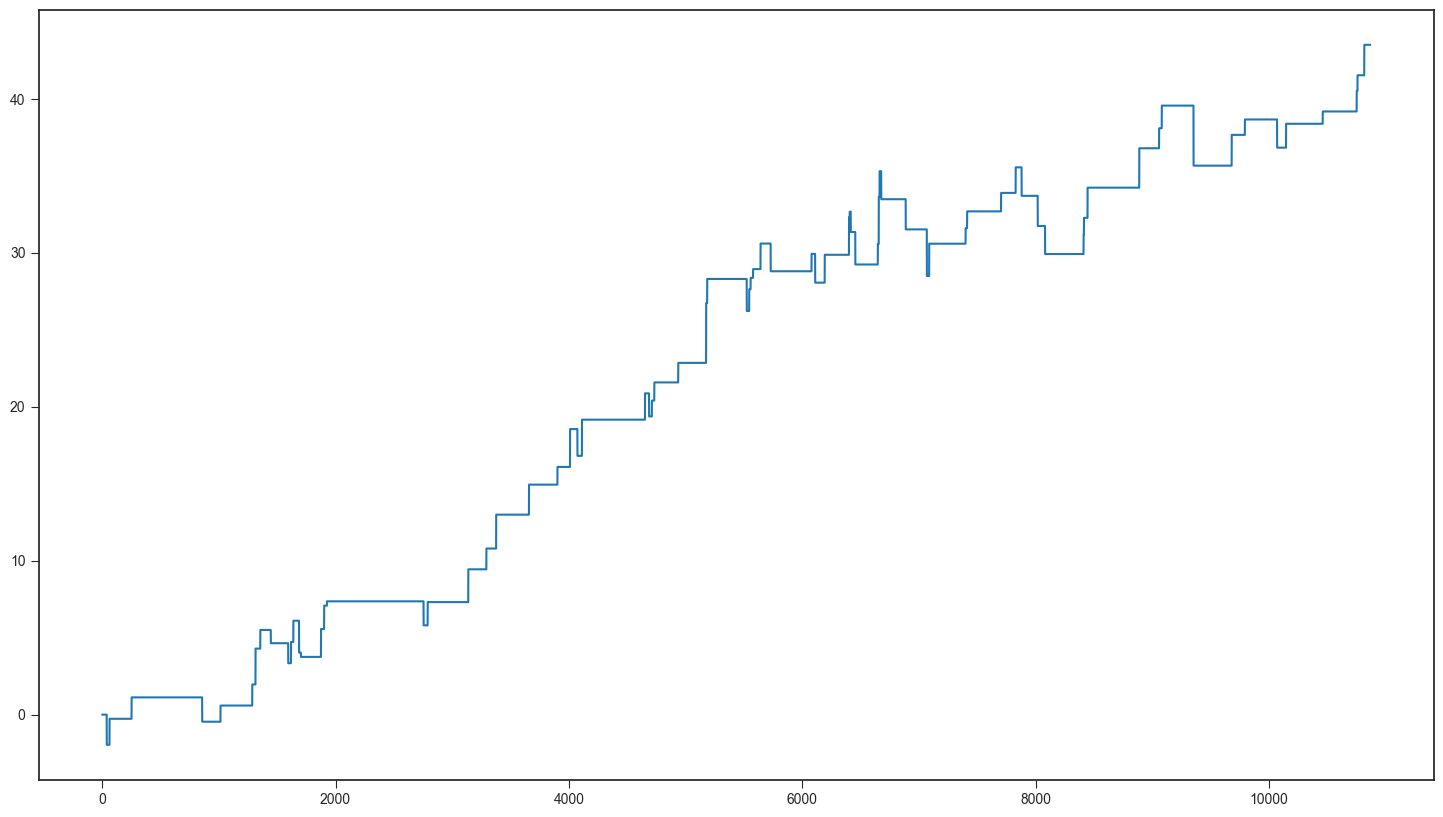

In [32]:
# Plot Equity Curves
fig = plt.figure(figsize=(18, 10))
plt.plot(pnl_list_list[fav_comb])
plt.show()
pnl = 0
max_pnl = 0
max_drawdown = 0
profit_list.clear()
pnl_list_list.clear()